In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

In [ ]:
import os
import zipfile

# Unzip the data
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('archive')




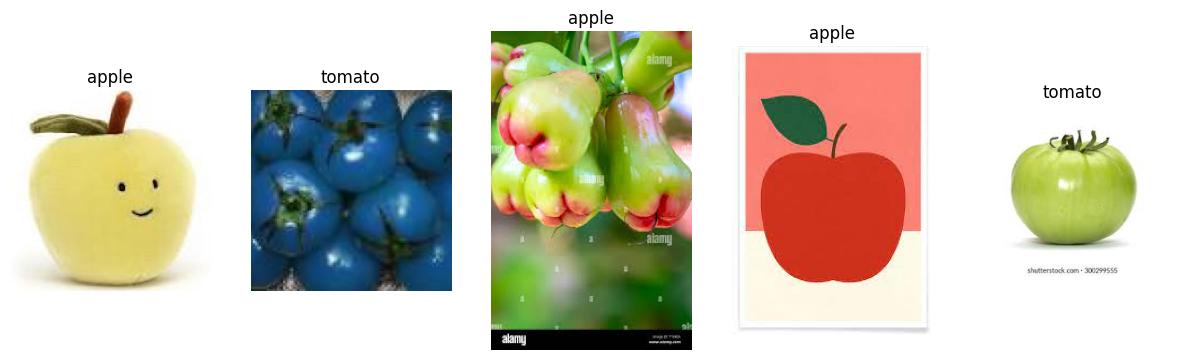

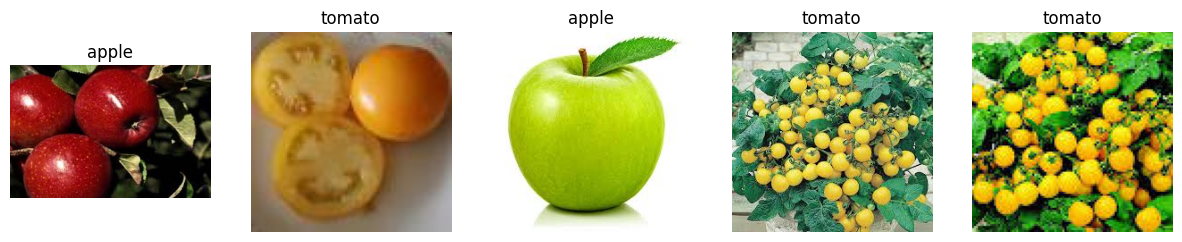

In [ ]:
import os
base_data_dir = 'archive'

def show_random_images(base_data_dir, num_images=5):
    tomatoes_dir = os.path.join(base_data_dir, 'tomatoes')
    apples_dir = os.path.join(base_data_dir, 'apples')

    # Get list of image files from both directories
    tomatoes_files = [os.path.join(tomatoes_dir, f) for f in os.listdir(tomatoes_dir) if os.path.isfile(os.path.join(tomatoes_dir, f))]
    apples_files = [os.path.join(apples_dir, f) for f in os.listdir(apples_dir) if os.path.isfile(os.path.join(apples_dir, f))]

    # Combine file paths and create corresponding labels
    all_files = tomatoes_files + apples_files
    all_labels = ['tomato'] * len(tomatoes_files) + ['apple'] * len(apples_files)

    # Shuffle the list of files and labels together
    combined = list(zip(all_files, all_labels))
    random.shuffle(combined)
    selected_files = combined[:num_images]

    # Display the images
    plt.figure(figsize=(15, 5))
    for i, (img_path, label) in enumerate(selected_files):
        try:
            img = Image.open(img_path)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
        except Exception as e:
            print(f"Could not open image {img_path}: {e}")

    plt.show()

train_data_path = os.path.join(base_data_dir, 'train')
show_random_images(train_data_path, num_images=5)

# Example usage: show random images from the test set
test_data_path = os.path.join(base_data_dir, 'test')
show_random_images(test_data_path, num_images=5)

In [ ]:
from sklearn.model_selection import train_test_split
import os

base_data_dir = 'archive/train'

apple_files = [os.path.join(base_data_dir, 'apples', f) for f in os.listdir(os.path.join(base_data_dir, 'apples'))]
tomato_files = [os.path.join(base_data_dir, 'tomatoes', f) for f in os.listdir(os.path.join(base_data_dir, 'tomatoes'))]

file_paths = apple_files + tomato_files
labels = [1] * len(apple_files) + [0] * len(tomato_files) # 1 for apple, 0 for tomato

train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels # Stratify to ensure even split
)

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
import os
from PIL import Image

class AppleTomato(Dataset):
    def __init__(self, file_paths, labels=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            # Assuming file name can be used for testing if no labels are provided
            return image, os.path.basename(img_path)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = AppleTomato(train_paths, train_labels, transform)
val_dataset = AppleTomato(val_paths, val_labels, transform)


from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
# test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Custom CNN with 2-output classifier
class AppleTomatoCNN(nn.Module):
    def __init__(self):
        super(AppleTomatoCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100352, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # 2 output neurons for cat and dog
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
from torchvision import models

class FineTunedResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)

        for param in self.base_model.parameters():
            param.requires_grad = False

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # <-- 2 classes: cat and dog
        )

    def forward(self, x):
        return self.base_model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AppleTomatoCNN().to(device)

In [ ]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FineTunedResNet().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


In [ ]:
#model.load_state_dict(torch.load(weights_path, map_location='gpu'))

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {count_parameters(model):,} number of trainable parameters.")

Model has 131,842 number of trainable parameters.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            train_loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0.0, 0
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for images, labels in val_loop:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_loop.set_postfix(val_loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, epochs=5
)

Epoch 1/5 => Train Loss: 0.6231, Acc: 0.6468 | Val Loss: 0.3690, Acc: 0.9492


Epoch 2/5 => Train Loss: 0.4014, Acc: 0.8468 | Val Loss: 0.2408, Acc: 0.9153


Epoch 3/5 => Train Loss: 0.3072, Acc: 0.8809 | Val Loss: 0.1850, Acc: 0.9492


Epoch 4/5 => Train Loss: 0.2453, Acc: 0.8936 | Val Loss: 0.1625, Acc: 0.9492


Epoch 5/5 => Train Loss: 0.2282, Acc: 0.9362 | Val Loss: 0.1921, Acc: 0.9322


In [ ]:
# train_losses, val_losses, train_accuracies, val_accuracies = train_model(
#     model, train_loader, val_loader, criterion, optimizer, device, epochs=5
# )

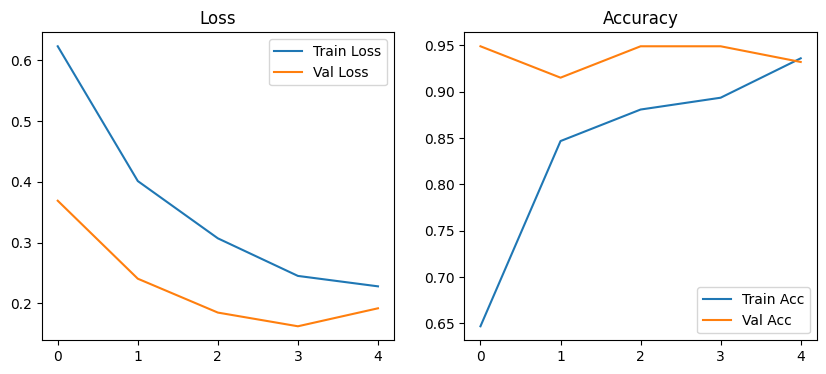

In [ ]:
# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
def plot_top_misclassified(model, dataloader, class_names=['apple', 'tomato'], device='cuda', top_n=5):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            mis_idx = preds != labels
            for i in range(images.size(0)):
                if mis_idx[i]:
                    misclassified.append((images[i].cpu(), preds[i].item(), labels[i].item()))

    misclassified_apple = [x for x in misclassified if x[2] == 0][:top_n]
    misclassified_tomato = [x for x in misclassified if x[2] == 1][:top_n]


    def show_images(examples, title):
        # Check if there are any examples to show
        if not examples:
            print(f"No {title.lower().replace('top misclassified ', '')} misclassified images to show.")
            return

        fig, axes = plt.subplots(1, len(examples), figsize=(4 * len(examples), 4))
        fig.suptitle(title, fontsize=16)
        if len(examples) == 1:
            axes = [axes]
        for ax, (img_tensor, pred, true) in zip(axes, examples):
            img = img_tensor.permute(1, 2, 0).numpy()
            # Unnormalize the image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.set_title(f'Pred: {class_names[pred]}\nTrue: {class_names[true]}', fontsize=12)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    show_images(misclassified_tomato, 'Top Misclassified Tomato')
    show_images(misclassified_apple, 'Top Misclassified Apple')

No tomato misclassified images to show.


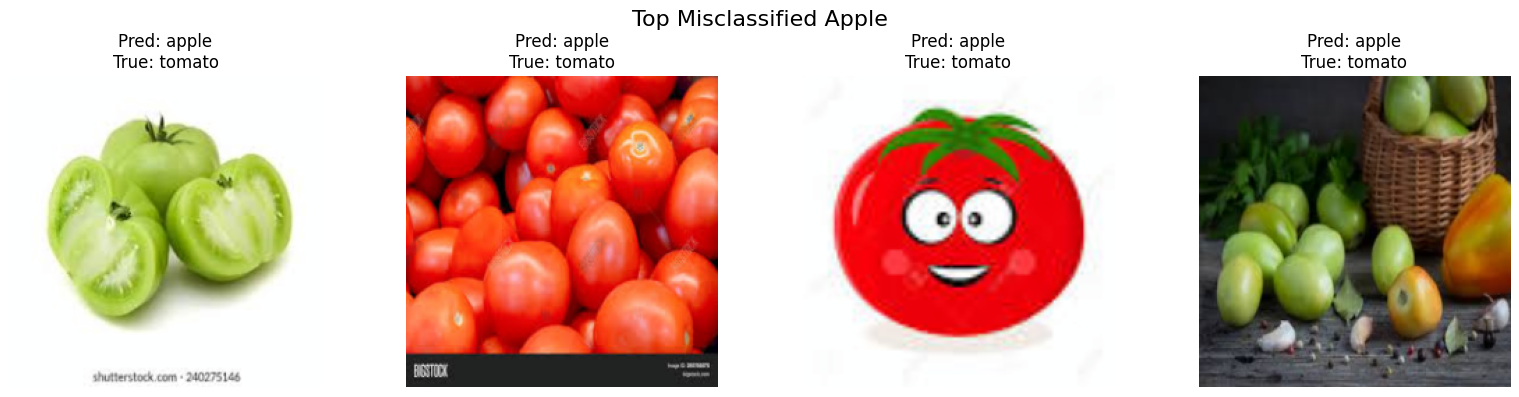

In [ ]:
class_names = ['tomato', 'apple']
plot_top_misclassified(model, val_loader, class_names, device)